Build feature and output arrays

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# One-Hot-Encoding für Turbinentypen
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# Datumsformat korrigieren
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features = []
output = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # Kombiniere alle Features
    combined_chunk = np.hstack((
        turbine_type_repeated,  # One-Hot Turbinen-Typ
        hub_height_repeated,    # Nabenhöhe
        capacity_repeated,      # Kapazität
        age_repeated,           # Alter
        wind_speeds             # Windgeschwindigkeit
    ))

    # Füge die Daten hinzu
    combined_features.append(combined_chunk)
    output.append(production_values)

# Kombinieren aller Datensätze in einem großen Array
combined_features = np.vstack(combined_features)
output = np.vstack(output)

# Alle Werte auf zwei Nachkommastellen runden
combined_features_raw = np.round(combined_features, decimals=2)
output_raw = np.round(output, decimals=2)

Extract subset of data for hyperparameter search

In [ ]:
import numpy as np

num_samples = 100000
random_indices = np.random.choice(combined_features_raw.shape[0], num_samples, replace=False)

combined_features_subset = combined_features_raw[random_indices].copy()
output_subset = output_raw[random_indices].copy()

Scale feature vector and define Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

combined_features = combined_features_subset.copy()
output = output_subset.copy()

# Standardisierung der numerischen Features
scaler = StandardScaler()
numerical_columns = slice(turbine_types_onehot.shape[1], combined_features.shape[1] - 1)
combined_features[:, numerical_columns] = scaler.fit_transform(combined_features[:, numerical_columns])

# Trainings- und Testaufteilung
train_features, test_features, train_targets, test_targets = train_test_split(
    combined_features, output, test_size=0.25, random_state=1
)

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
train_val_dataset = WindPowerDataset(train_features, train_targets)
test_dataset = WindPowerDataset(test_features, test_targets)

# Ausgabe der Formen
print("Train Features Shape:", train_features.shape)
print("Train Targets Shape:", train_targets.shape)
print("Test Features Shape:", test_features.shape)
print("Test Targets Shape:", test_targets.shape)

Define Model

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)  # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # No activation in the output layer for regression
        return x

Hyperparameter search: Training, Validation

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import shutil
import os
import subprocess
from torch.utils.tensorboard import SummaryWriter

# Hyperparameter-Raum definieren
# param_space = {
#     "hidden_size": [32, 64, 128, 256],
#     "batch_size": [16, 32, 64],
#     "lr": [1e-2, 1e-3, 1e-4],
#     "number_epochs": [20, 50, 100],
# }
param_space = {
    "hidden_size": [16],
    "batch_size": [64],
    "lr": [1e-3],
    "number_epochs": [20],
}

# Funktion zur Auswahl eines zufälligen Parametersets
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

# Generiere zufällige Parameterkombinationen
n_trials = 1
params = random_search(param_space, n_trials)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KFold-Objekt
kf = KFold(n_splits=2, shuffle=True, random_state=1)
len_train_val_dataset = len(train_val_dataset)

# Ergebnis-Tracking
best_val_loss = float("inf")
best_params = None
results = []

input_size = train_features.shape[1]

# TensorBoard-Prozess beenden
try:
    subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    print("TensorBoard-Prozess beendet.")
except subprocess.CalledProcessError:
    print("Kein TensorBoard-Prozess gefunden oder konnte nicht beendet werden.")

log_dir = "runs"

# Löschen, wenn der Ordner existiert
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# TensorBoard neu starten
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard gestartet.")

avg_val_loss = 0.0  # Durchschnittliche Validierungs-Fehler über die Folds

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):

    print(f"  Fold {fold}/{kf.n_splits}")
    writer = SummaryWriter(f"{log_dir}/fold_{fold}")

    # Modell
    example_input = torch.randn(params["batch_size"], input_size).to(device)
    model = MLP(input_size=input_size, hidden_size=params["hidden_size"], output_size=1).to(device)

    # Visualisierung der Modellarchitektur
    writer.add_graph(model, example_input)

    # Train- und Validierungsdaten erstellen
    train_fold_dataset = Subset(train_val_dataset, train_idx)
    val_fold_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_fold_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=params["batch_size"], shuffle=False)

    # Loss und Optimizer
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    for epoch in range(params["number_epochs"]):
        print(f"    Epoch {epoch+1}/{params['number_epochs']}")
        model.train()
        training_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            training_loss += loss.item()

            optimizer.zero_grad()  # Gradienten zurücksetzen
            loss.backward()        # Gradienten berechnen
            optimizer.step()       # Parameter aktualisieren

        # Trainingsverlust protokollieren
        writer.add_scalar("Training Loss", training_loss / len(train_loader), epoch)

    # Validierung
    model.eval()
    fold_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            val_outputs = model(batch_x)
            fold_val_loss += criterion(val_outputs, batch_y).item()

    fold_val_loss /= len(val_loader)
    writer.add_scalar("Validation Loss", fold_val_loss, 1)
    print(f"    Fold Validation Loss: {fold_val_loss:.4f}")
    avg_val_loss += fold_val_loss

    # TensorBoard schließen
    writer.close()

avg_val_loss /= kf.n_splits
print(f"  Trial Average Validation Loss: {avg_val_loss:.4f}")

# Ergebnisse speichern
results.append({"params": params, "avg_val_loss": avg_val_loss})

# Bestes Ergebnis aktualisieren
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

With best hyperparameters: Training and Testing

In [ ]:

# Test mit besten Parametern
example_input = torch.randn(best_params["batch_size"], input_size).to(device)
model = torch.jit.trace(
    MLP(input_size=input_size, hidden_size=best_params["hidden_size"], output_size=1).to(device), example_input
)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

train_loader = DataLoader(train_val_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Training mit besten Parametern
for epoch in range(best_params["number_epochs"]):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test mit Testdaten
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        test_outputs = model(batch_x)
        test_loss += criterion(test_outputs, batch_y).item()

test_loss /= len(test_loader)
print(f"\nTest Loss: {test_loss:.4f}")

# Modell speichern
torch.save(model.state_dict(), "mlp_wind_power_model_best.pth")

Benchmarking with representative power curve

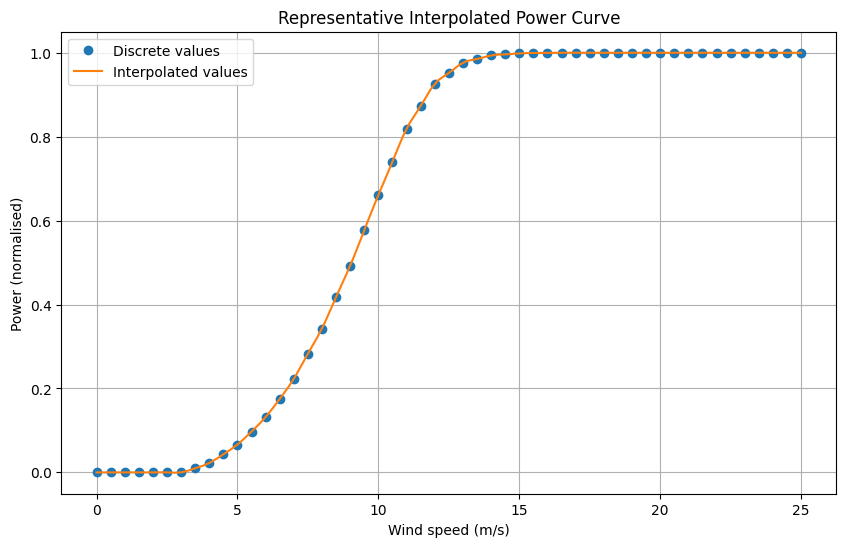

In [35]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Definiere die Power Curve (Windgeschwindigkeit und Leistung)
wind_speeds = np.arange(0, 25.5, 0.5)  # Windgeschwindigkeiten
power_output = [0]*7 + [35, 80, 155, 238, 350, 474, 630, 802, 1018, 1234, 1504, 1773, 2076, 2379, 2664, 2948, 3141, 3334, 3425, 3515, 3546, 3577, 3586, 3594, 3598, 3599] + [3600]*18  # Leistung
max_cap = 3600
power_output_norm = [x / max_cap for x in power_output]
wind_speed_max = 25

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate")

# Beispiel für Interpolation: Bestimme Werte für feinere Windgeschwindigkeiten
fine_wind_speeds = np.linspace(0, 25, 100)  # Feinere Windgeschwindigkeiten
interpolated_power_output = interpolation_function(fine_wind_speeds)

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, power_output_norm, 'o', label='Discrete values')
plt.plot(fine_wind_speeds, interpolated_power_output, '-', label='Interpolated values')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (normalised)')
plt.title('Representative Interpolated Power Curve')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Extrahiere relevante Spalten
wind_speeds_data = combined_features_subset[:, -1]
capacities = combined_features_subset[:, -3]
actual_power_output = output_subset.flatten()

# Vorhersage basierend auf Power Curve
predicted_power_output = interpolation_function(wind_speeds_data) * capacities

# Setze vorhergesagte Leistung auf 0 für Windgeschwindigkeiten über wind_speed_max
predicted_power_output[wind_speeds_data > wind_speed_max] = 0

In [37]:
import torch

predicted_torch = torch.tensor(predicted_power_output, dtype=torch.float32)
actual_torch = torch.tensor(actual_power_output, dtype=torch.float32)

# Berechne den Huber Loss
huber_loss_fn = torch.nn.HuberLoss()
huber_loss_value = huber_loss_fn(predicted_torch, actual_torch).item()
print(f"Huber Loss: {huber_loss_value:.2f}")

# Berechne den MAE Loss
mae_loss_fn = torch.nn.L1Loss()  # L1 Loss entspricht MAE
mae_loss_value = mae_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Absolute Error (MAE): {mae_loss_value:.2f} MW")

# Berechne den MSE Loss
mse_loss_fn = torch.nn.MSELoss()
mse_loss_value = mse_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Squared Error (MSE): {mse_loss_value:.2f} MW²")

Huber Loss: 25.12
Mean Absolute Error (MAE): 25.58 MW
Mean Squared Error (MSE): 2613.75 MW²


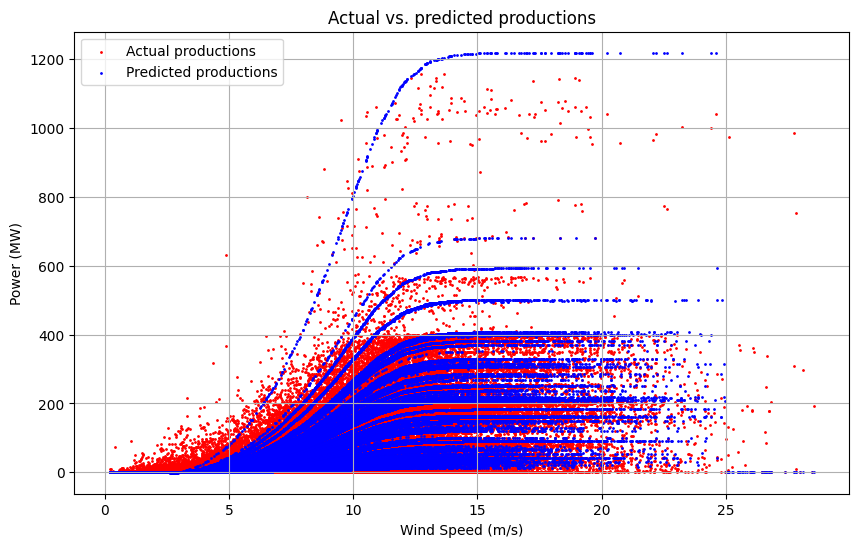

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, actual_power_output, color='red', s=1, label='Actual productions')
plt.scatter(wind_speeds_data, predicted_power_output, color='blue', s=1, label='Predicted productions')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual vs. predicted productions')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_43560\2941495794.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


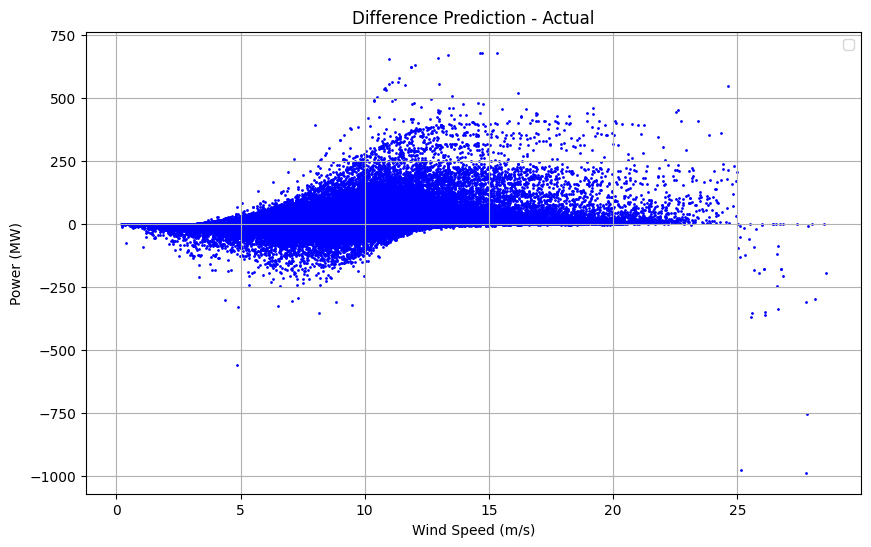

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, predicted_power_output-actual_power_output, color='blue', s=1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Difference Prediction - Actual')
plt.legend()
plt.grid(True)
plt.show()

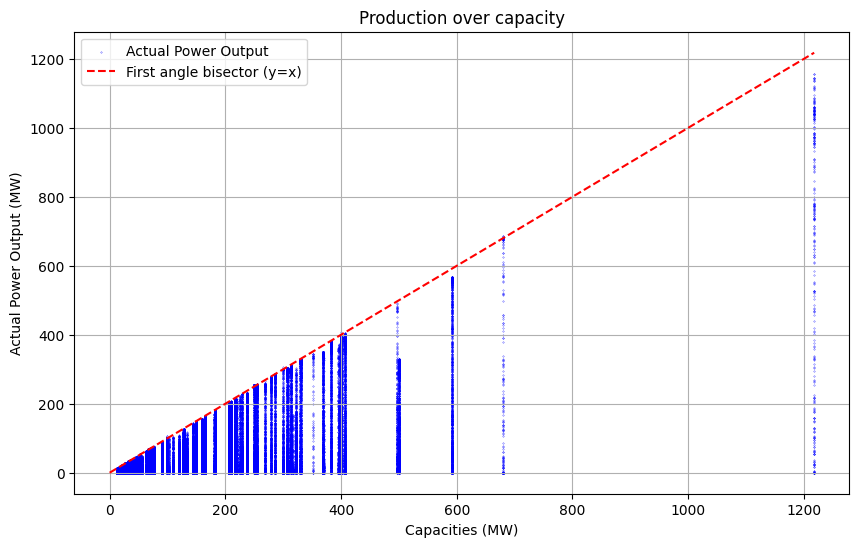

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(capacities, actual_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Capacities (MW)')
plt.ylabel('Actual Power Output (MW)')
plt.title('Production over capacity')
plt.legend()
plt.grid(True)
plt.show()